In [3]:
import math
import latexify
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import random

## Monte Carlo Prediction
### First-visit MC prediction, for estimating $V \approx v_{\pi}$

In [22]:
r = {i: np.exp(i)-1 if i < 5 else i+3 for i in range(1, 10)}

In [19]:
def Value_S(n_episodes,n_states, T, rewards, gamma = 1):
    V = defaultdict(float)
    v_s = defaultdict(list)
    returns= defaultdict(list)
    for e in range(n_episodes):
        steps = [random.randint(1, n_states) for _ in range(T)]
        visited_states = []
        G = 0
        for s in reversed(steps):
            G = gamma*G + rewards[s]
            if s not in visited_states:
                visited_states.append(s)
                returns[s].append(G)
                V[s] = np.mean(returns[s])
                v_s[s].append(np.mean(returns[s]))
    return V, returns, v_s

In [20]:
my_val, returns, v_s = Value_S(10000, 4, 10, r)

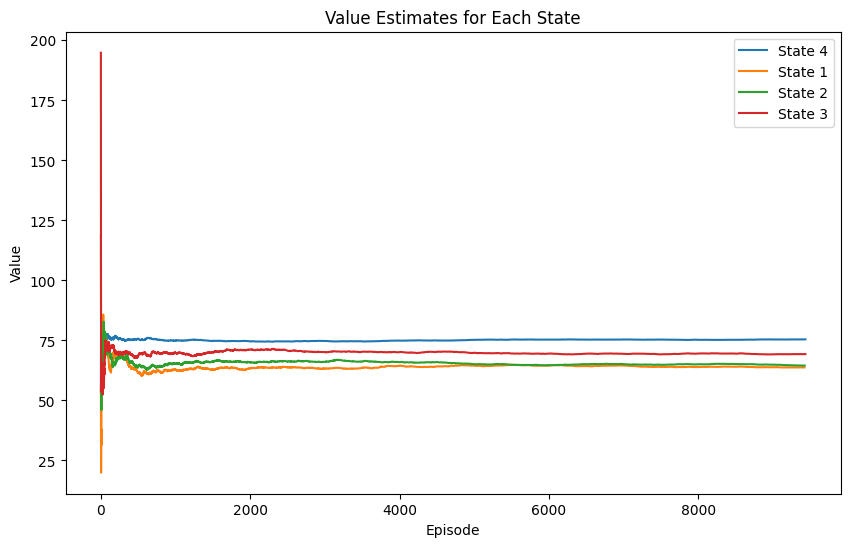

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
for key, values in v_s.items():
    ax.plot(values, label=f'State {key}')
ax.set_xlabel('Episode')
ax.set_ylabel('Value')
ax.set_title('Value Estimates for Each State')
ax.legend()
plt.show()

## Monte Carlo Control
### Monte Carlo ES (Exploring Starts), for estimating $\pi \approx \pi_*$

In [24]:
import numpy as np
from collections import defaultdict

def initialize(states, actions):
    pi = {s: np.random.choice(actions) for s in states}  # Arbitrary policy
    Q = {(s, a): 0.0 for s in states for a in actions}  # Arbitrary action-value function
    Returns = defaultdict(list)  # Empty list for each state-action pair
    return pi, Q, Returns

def generate_episode(pi, env, start_state, start_action):
    episode = []
    state = start_state
    action = start_action
    while True:
        next_state, reward, done, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
        action = pi[state]
    return episode

def monte_carlo_es(env, states, actions, gamma=1.0, episodes=1000, epsilon=0.1):
    pi, Q, Returns = initialize(states, actions)
    
    for _ in range(episodes):
        start_state = np.random.choice(states)
        start_action = np.random.choice(actions)
        episode = generate_episode(pi, env, start_state, start_action)
        G = 0
        visited_state_action_pairs = set()
        
        for t in range(len(episode) - 1, -1, -1):
            state, action, reward = episode[t]
            G = gamma * G + reward
            
            if (state, action) not in visited_state_action_pairs:
                visited_state_action_pairs.add((state, action))
                Returns[(state, action)].append(G)
                Q[(state, action)] = np.mean(Returns[(state, action)])
                pi[state] = max(actions, key=lambda a: Q[(state, a)])
    
    return pi, Q

# Example usage with a hypothetical environment
class DummyEnv:
    def reset(self):
        return 0  # Starting state
    
    def step(self, action):
        next_state = np.random.choice([0, 1])
        reward = np.random.choice([0, 1])
        done = np.random.choice([True, False])
        return next_state, reward, done, {}

# Define states and actions
states = [0, 1]
actions = [0, 1]

# Create environment
env = DummyEnv()

# Run Monte Carlo ES
pi, Q = monte_carlo_es(env, states, actions)

print("Optimal Policy:", pi)
print("Action-Value Function:", Q)

Estimated Policy:
State 0: Action 1
State 1: Action 0
State 2: Action 0
State 3: Action 0

Estimated Q-values:
State 2: [-2. -2.]
State 1: [-4. -4.]
State 0: [-5. -4.]
State 3: [0. 0.]


In [6]:
states = [0, 1, 2, 3]
actions = [0, 1]
current_state = 0

## Monte Carlo Control without Exploring Starts
### On-policy first-visit MC control (for $\epsilon$-soft policies), estimating $\pi \approx \pi_*$

In [33]:
import numpy as np
from collections import defaultdict
import random

class SimpleEnv:
    def __init__(self):
        self.states = [0, 1, 2, 3]
        self.actions = [0, 1]
        self.current_state = 0
    
    def reset(self):
        self.current_state = random.choice(self.states)
        return self.current_state
    
    def step(self, action):
        if self.current_state == 0:
            if action == 0:
                self.current_state = 1
                return 1, -1, False, {}
            else:
                self.current_state = 2
                return 2, -2, False, {}
        elif self.current_state == 1:
            self.current_state = 2
            return 2, -2, False, {}
        elif self.current_state == 2:
            self.current_state = 3
            return 3, -2, True, {}
        elif self.current_state == 3:
            return 3, 0, True, {}

def epsilon_soft_policy(Q, state, n_actions, epsilon):
    policy = np.ones(n_actions) * epsilon / n_actions
    best_action = np.argmax(Q[state])
    policy[best_action] += (1.0 - epsilon)
    return policy

def on_policy_first_visit_mc_control(env, num_episodes, gamma=1.0, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(len(env.actions)))
    returns = defaultdict(list)
    policy = {s: epsilon_soft_policy(Q, s, len(env.actions), epsilon) for s in env.states}
    
    for _ in range(num_episodes):
        # Generate an episode following the policy
        episode = []
        state = env.reset()
        done = False
        while not done:
            action = np.random.choice(env.actions, p=policy[state])
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            state = next_state
        
        # Calculate returns and update Q and policy
        G = 0
        visited_state_action_pairs = set()
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = gamma * G + reward
            if (state, action) not in visited_state_action_pairs:
                visited_state_action_pairs.add((state, action))
                returns[(state, action)].append(G)
                Q[state][action] = np.mean(returns[(state, action)])
                best_action = np.argmax(Q[state])
                for a in env.actions:
                    if a == best_action:
                        policy[state][a] = 1 - epsilon + epsilon / len(env.actions)
                    else:
                        policy[state][a] = epsilon / len(env.actions)
    
    return policy, Q

# Example usage
env = SimpleEnv()
num_episodes = 1000
policy, Q = on_policy_first_visit_mc_control(env, num_episodes)

# Print the estimated policy and Q-values
print("Estimated Policy:")
for state in policy:
    print(f"State {state}: {policy[state]}")

print("\nEstimated Q-values:")
for state in Q:
    print(f"State {state}: {Q[state]}")

Estimated Policy:
State 0: [0.475 0.525]
State 1: [0.525 0.475]
State 2: [0.525 0.475]
State 3: [0.525 0.475]

Estimated Q-values:
State 0: [-5. -4.]
State 1: [-4. -4.]
State 2: [-2. -2.]
State 3: [0. 0.]


## Incremental Implementation (Off-policy Prediction via Importance Sampling)
### Off-policy MC prediction (policy evaluation) for estimating $Q \approx q_\pi$ 

In [31]:
class Policy:
    def __init__(self, policy_func):
        self.policy_func = policy_func

    def __call__(self, state):
        return self.policy_func(state)

    def prob(self, action, state):
        if self.policy_func(state) == action:
            return 1.0
        else:
            return 0.33  # Assuming equal probability for random policy
# class RandomPolicy(Policy):
#     def prob(self, action, state):
#         return 1.0 / len(self.actions) 
# Define the target policy function
def target_policy(state):
    """Discharge if state is 'low', ongoing care if 'medium', transfer if 'high'."""
    if state == 'low':
        return 'discharge'
    elif state == 'medium':
        return 'ongoing care'
    else:
        return 'transfer to other ward'

# Define the behavior policy function
def behavior_policy(state):
    """Randomly choose an action."""
    return np.random.choice(['discharge', 'ongoing care', 'transfer to other ward'])

# Create policy instances
target_policy_instance = Policy(target_policy)
behavior_policy_instance = Policy(behavior_policy)

# behavior_policy_instance = RandomPolicy(behavior_policy, actions)

def generate_episode(env, policy):
    """
    Generate an episode following the given policy.

    Args:
        env: The environment.
        policy: The policy to follow.

    Returns:
        episode: A list of (state, action, reward) tuples.
    """
    episode = []
    state = env.reset()
    done = False

    while not done:
        action = policy(state)
        next_state, reward, done, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state

    return episode

def off_policy_mc_prediction(env, target_policy, behavior_policy, gamma=1.0, num_episodes=10000):
    """
    Off-policy Monte Carlo prediction for estimating Q ≈ q_π.

    Args:
        env: The environment.
        target_policy: The target policy π.
        behavior_policy: The behavior policy b.
        gamma: Discount factor.
        num_episodes: Number of episodes to run.

    Returns:
        Q: The state-action value function.
    """
    Q = defaultdict(lambda: {action: np.random.rand() for action in ['discharge', 'ongoing care', 'transfer to other ward']})
    C = defaultdict(lambda: {action: 0.0 for action in ['discharge', 'ongoing care', 'transfer to other ward']})
    Q_values = defaultdict(lambda: {action: [] for action in ['discharge', 'ongoing care', 'transfer to other ward']})

    for episode in range(num_episodes):
        episode_data = generate_episode(env, behavior_policy_instance)
        G = 0
        W = 1

        for t in reversed(range(len(episode_data))):
            S_t, A_t, R_t1 = episode_data[t]
            G = gamma * G + R_t1
            C[S_t][A_t] += W
            Q[S_t][A_t] += (W / C[S_t][A_t]) * (G - Q[S_t][A_t])
            Q_values[S_t][A_t].append(Q[S_t][A_t])
            W *= target_policy_instance.prob(A_t, S_t) / behavior_policy_instance.prob(A_t, S_t)
            if W == 0:
                break

    return Q, Q_values

# Example environment class
class HospitalEnv:
    def __init__(self):
        self.state_space = ['low', 'medium', 'high']  # Example state space
        self.state = random.choice(self.state_space)

    def reset(self):
        self.state = random.choice(self.state_space)
        return self.state

    def step(self, action):
        if action == 'discharge' and self.state == 'low':
            reward = +4  # Discharge and state is low
        elif action == 'discharge' and self.state == 'medium':
            reward = +3  # Discharge and state is medium
        elif action == 'discharge' and self.state == 'high':
            reward = +2  # Discharge and state is high
        elif action == 'ongoing care' and self.state == 'low':
            reward = -1  # Ongoing care and state is low
        elif action == 'ongoing care' and self.state == 'medium':
            reward = 0  # Ongoing care and state is medium
        elif action == 'ongoing care' and self.state == 'high':
            reward = +1  # Ongoing care and state is high
        elif action == 'transfer to other ward' and self.state == 'high':
            reward = -2  # Transfer and state is high
        elif action == 'transfer to other ward' and self.state == 'low':
            reward = -1  # Transfer and state is high
        else:
            reward = -1  # Any other action-state combination
        done = np.random.rand() < 0.1  # End episode with 10% probability
        self.state = random.choice(self.state_space)  # Randomly transition to a new state
        return self.state, reward, done, {}

# Create the Hospital environment
env = HospitalEnv()

# Run the off-policy MC prediction algorithm
Q, Q_V = off_policy_mc_prediction(env, target_policy_instance, behavior_policy_instance, num_episodes=10000)

# Print the estimated action-value function
for state, actions in Q.items():
    print(f"State: {state}, Actions: {actions}")

State: high, Actions: {'discharge': 33.559139188410256, 'ongoing care': 37.78793859362933, 'transfer to other ward': 39.7422146010955}
State: medium, Actions: {'discharge': 27.65488269887011, 'ongoing care': 28.262722308488133, 'transfer to other ward': 14.057149044582227}
State: low, Actions: {'discharge': 42.037880067550425, 'ongoing care': 32.478764126731264, 'transfer to other ward': 26.51464256869759}


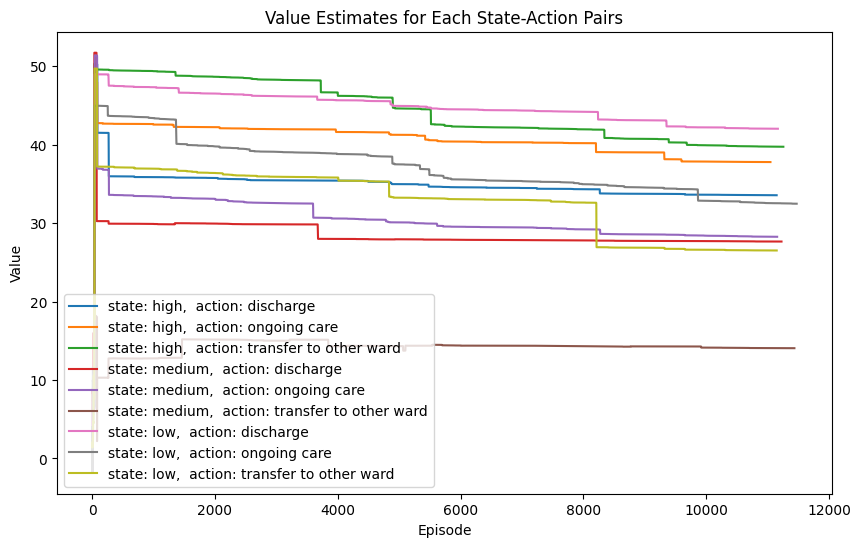

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))
for key, values in Q_V.items():
    for k, v in values.items():
        ax.plot(v, label=f'state: {key},  action: {k}')
ax.set_xlabel('Episode')
ax.set_ylabel('Value')
ax.set_title('Value Estimates for Each State-Action Pairs')
ax.legend(loc='lower left')
plt.show()

## Off-policy Monte Carlo Control

### Off-policy MC control, for estimating $\pi \approx \pi_*$

In [ ]:
class Policy:
    def __init__(self, policy_func, actions):
        self.policy_func = policy_func
        self.actions = actions

    def __call__(self, state):
        return self.policy_func(state)

    def prob(self, action, state):
        if self.policy_func(state) == action:
            return 1.0
        else:
            return 1.0 / len(self.actions)

def soft_policy(state, actions):
    return np.random.choice(actions)

def generate_episode(env, policy):
    episode = []
    state = env.reset()
    done = False

    while not done:
        action = policy(state)
        next_state, reward, done, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state

    return episode

def off_policy_mc_control(env, gamma=1.0, num_episodes=10000):
    actions = ['discharge', 'ongoing care', 'transfer to other ward']
    Q = defaultdict(lambda: {action: np.random.rand() for action in actions})
    C = defaultdict(lambda: {action: 0.0 for action in actions})
    pi = defaultdict(lambda: np.random.choice(actions))

    for state in env.state_space:
        pi[state] = max(Q[state], key=Q[state].get)

    for episode in range(num_episodes):
        episode_data = generate_episode(env, lambda state: soft_policy(state, actions))
        G = 0
        W = 1

        for t in reversed(range(len(episode_data))):
            S_t, A_t, R_t1 = episode_data[t]
            G = gamma * G + R_t1
            C[S_t][A_t] += W
            Q[S_t][A_t] += (W / C[S_t][A_t]) * (G - Q[S_t][A_t])
            pi[S_t] = max(Q[S_t], key=Q[S_t].get) # Find the key with the maximum value
            if A_t != pi[S_t]:
                break
            W *= 1.0 / (1.0 / len(actions))

    return Q, pi

# Example environment class
class HospitalEnv:
    def __init__(self):
        self.state_space = ['low', 'medium', 'high']  # Example state space
        self.state = random.choice(self.state_space)

    def reset(self):
        self.state = random.choice(self.state_space)
        return self.state

    def step(self, action):
        if action == 'discharge' and self.state == 'low':
            reward = 1  # Discharge and state is low
        elif action == 'ongoing care' and self.state == 'medium':
            reward = 1  # Ongoing care and state is medium
        elif action == 'transfer to other ward' and self.state == 'high':
            reward = 1  # Transfer and state is high
        else:
            reward = -1  # Any other action-state combination
        done = np.random.rand() < 0.1  # End episode with 10% probability
        self.state = random.choice(self.state_space)  # Randomly transition to a new state
        return self.state, reward, done, {}

# Create the Hospital environment
env = HospitalEnv()

# Run the off-policy MC control algorithm
Q, pi = off_policy_mc_control(env, num_episodes=10000)

# Print the estimated action-value function and policy
for state, actions in Q.items():
    print(f"State: {state}, Actions: {actions}")
print("\nPolicy:")
for state, action in pi.items():
    print(f"State: {state}, Action: {action}")

In [1]:
import numpy as np